# House Prices: Advanced Regression Techniques

**
주어진 feature 기반으로 주택의 SalesPrice 를 예측하는 regression 문제임.  
Tensorflow(1.4+)로 학습을 통해 예측 모델을 만드는 방법은 네 가지 정도로 볼 수 있음.
**

1.가설함수(hypothesis), 손실함수(loss), 가중치(W), 바이어스(b) 등을 정의하고 neural network 를 직접 구현하는 방법
2.tensorflow.layers 같은 High level API 를 사용하여 neural network 를 구현하는 방법  
3.tensorflow.estimators 같은 High level API를 사용하여 neural network 를 구현하는 방법  
4.tensorflow.keras or Keras 같은 High level API를 사용하여 neural network 를 구현하는 방법  

여기서는 첫번째, tensorflow 기본 Row level API를 사용하여 multi-layer neural network 를 구현한다.

확인 할 내용

- 입력 feature 들에 대한 전처리, 사용할 feature 선택에 따른 차이.
- 가중치 초기화를 random 으로 했을 경우, Xavier/He initializer 를 사용했을 경우 차이.
- 활성화 함수(sigmoid/tanh/relu) 사용에 따른 차이.
- Layer 수, Layer 별 neuron 수에 따른 차이.
- Optimizer 사용에 따른 차이 (GradientDescent, Adam 등)

* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Dataset

In [2]:
# train data
train = pd.read_csv("data/train.csv", index_col="Id")

print(train.shape)
train.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# test data
test = pd.read_csv("data/test.csv", index_col="Id")

print(test.shape)
test.head()

(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Preprocessing

#### linear regression 에서 feature 를 선택하는 방법
1. 데이터 탐색을 통해 SalePrice 와 선형 상관관계가 높고, 선형 regression 전제조건을 충족하는 feature 선택
2. 모든 feature 를 사용하고 Backward Elimination 을 통해 feature 를 줄여나가는 방법

#### sklearn linear regression 에서 feature scaling 이 필요한가?
1. linear regression 에서는 자동으로 feature scaling 되는것으로 알고 있음
   - SVN, K-Mean, Logistic Regression 처럼 feature scaling 이 필요한 모델들도 있음
   - from sklearn.preprocessing import StandardScaler 사용
2. lenear regression 에서 feature scaling 을 했을경우와 안했을경우 차이를 확인해 보자
   - 차이가 없음 : 자동으로 feature scaling 되고 있음

### outlier

1. outlier 데이터 제거 (GrLivArea, SalePrice 데이터 탐색 결과)

In [4]:
# 차트를 jupyter notebook에 출력해서 보기 위한 명령어
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

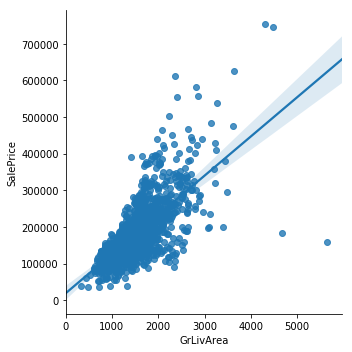

In [5]:
sns.lmplot(data=train, x="GrLivArea", y="SalePrice", fit_reg=True)

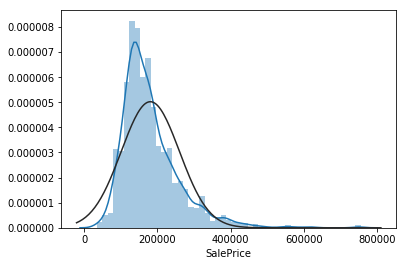

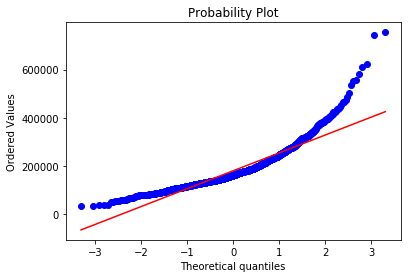

In [6]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [7]:
train = train.drop(
    train[(train['GrLivArea']>4000) & (train['SalePrice']<400000)].index)

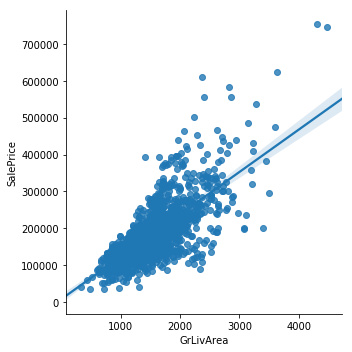

In [8]:
sns.lmplot(data=train, x="GrLivArea", y="SalePrice", fit_reg=True)

### One hot encoding

Categorical 데이터를 모두 one hot encoding 처리하기 위한 작업

numeric 데이터처럼 보이지만 categorical 데이터인 feature 들의 데이터타입을 string 으로 변환해서 one hot encoding이 되도록 함

In [9]:
# one-hot encoding 시 train/test 데이터의 feature 들이 가지고 있는 값들이 다르면 dummy column 갯수에 차이가 날 수 있음
# 하나로 합쳐놓고 전처리 한 다음에 다시 나누도록..
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print(all_data.shape)
all_data.head()

(2917, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2917 non-null int64
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 non

In [11]:
# Drop utilities column
all_data = all_data.drop(['Utilities'], axis=1)

In [12]:
# Impute missing categorical values
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [13]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

#### Transform numerical to categorical

In [14]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallQual'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [15]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### One hot encoding

In [16]:
# Analyze data skewness
from scipy.stats import skew

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [17]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
    
all_data.loc[:, cols].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,3,2,4,5,5,2,4,0,3,2,...,0,3,2,1,1,1,10,4,2,4
2,5,2,4,5,5,3,4,0,3,3,...,0,3,2,1,1,1,5,7,1,7
3,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,11
4,2,4,1,5,5,3,4,2,3,2,...,0,0,2,1,1,1,11,4,0,4
5,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,3


In [18]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].apply(str)
all_data['ExterQual'] = all_data['ExterQual'].apply(str)
all_data['ExterCond'] = all_data['ExterCond'].apply(str)
all_data['BsmtQual'] = all_data['BsmtQual'].apply(str)
all_data['ExterBsmtCond'] = all_data['BsmtCond'].apply(str)

In [19]:
# categorical 데이터를 one hot encoding
all_data_enc = pd.get_dummies(all_data)
print(all_data_enc.shape)
all_data_enc.head()

all_data_enc.to_csv('features.csv', index=False)

(2917, 267)


In [20]:
# train 시킬 데이터셋
X_train = all_data_enc[:train.shape[0]]

print(X_train.shape)
X_train.tail()

(1458, 267)


,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,BsmtCond,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,ExterBsmtCond_0,ExterBsmtCond_1,ExterBsmtCond_2,ExterBsmtCond_3,ExterBsmtCond_4
Id,,,,,,,,,,,,,,,,,,,,,
1456,4.143135,8.976894,1,1,3,0,1999,2000,0.000000,4,...,0,0,0,1,0,0,0,0,0,1
1457,4.454347,9.486152,1,1,3,0,1978,1988,4.787492,4,...,0,0,0,1,0,0,0,0,0,1
1458,4.204693,9.109746,1,1,3,0,1941,2006,0.000000,1,...,0,0,0,1,0,0,1,0,0,0
1459,4.234107,9.181735,1,1,3,0,1950,1996,0.000000,4,...,0,0,0,1,0,0,0,0,0,1
1460,4.330733,9.204121,1,1,3,0,1965,1965,0.000000,4,...,0,0,0,1,0,0,0,0,0,1


In [21]:
# test 데이터셋
X_submit = all_data_enc[train.shape[0]:]

print(X_submit.shape)
X_submit.head()

(1459, 267)


,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,BsmtCond,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,ExterBsmtCond_0,ExterBsmtCond_1,ExterBsmtCond_2,ExterBsmtCond_3,ExterBsmtCond_4
Id,,,,,,,,,,,,,,,,,,,,,
1461,4.394449,9.360741,1,1,3,0,1961,1961,0.000000,4,...,0,0,0,1,0,0,0,0,0,1
1462,4.406719,9.565775,1,1,0,0,1958,1958,4.691348,4,...,0,0,0,1,0,0,0,0,0,1
1463,4.317488,9.534668,1,1,0,0,1997,1998,0.000000,4,...,0,0,0,1,0,0,0,0,0,1
1464,4.369448,9.208238,1,1,0,0,1998,1998,3.044522,4,...,0,0,0,1,0,0,0,0,0,1
1465,3.784190,8.518392,1,1,0,0,1992,1992,0.000000,4,...,0,0,0,1,0,0,0,0,0,1


### missing data in X_train

In [22]:
#missing data
total = X_train.isnull().sum().sort_values(ascending=False)
percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
ExterBsmtCond_4,0,0.0
Neighborhood_Blmngtn,0,0.0
Neighborhood_NWAmes,0,0.0
Neighborhood_NPkVill,0,0.0
Neighborhood_NAmes,0,0.0


### missing data in X_submit

In [23]:
#missing data
total = X_submit.isnull().sum().sort_values(ascending=False)
percent = (X_submit.isnull().sum()/X_submit.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
ExterBsmtCond_4,0,0.0
Neighborhood_Blmngtn,0,0.0
Neighborhood_NWAmes,0,0.0
Neighborhood_NPkVill,0,0.0
Neighborhood_NAmes,0,0.0


In [24]:
# TotalBsmtSF null 값 확인
X_submit[X_submit['TotalBsmtSF'].isnull()]

,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,BsmtCond,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,ExterBsmtCond_0,ExterBsmtCond_1,ExterBsmtCond_2,ExterBsmtCond_3,ExterBsmtCond_4
Id,,,,,,,,,,,,,,,,,,,,,


In [25]:
# 결측치를 평균값으로 채움
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_submit["TotalBsmtSF"]=imp.fit_transform(X_submit[["TotalBsmtSF"]]).ravel()

# total_bsmtsf_mean = X_submit['TotalBsmtSF'].mean()
# X_submit.loc[X_submit['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = total_bsmtsf_mean

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
# GarageCars null 값 확인
X_submit[X_submit['GarageCars'].isnull()]

,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,BsmtCond,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,ExterBsmtCond_0,ExterBsmtCond_1,ExterBsmtCond_2,ExterBsmtCond_3,ExterBsmtCond_4
Id,,,,,,,,,,,,,,,,,,,,,


In [27]:
# 결측치를 평균값으로 채움
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_submit["GarageCars"]=imp.fit_transform(X_submit[["GarageCars"]]).ravel()

# garagecars_mean = X_submit['GarageCars'].mean()
# X_submit.loc[X_submit['GarageCars'].isnull(), 'GarageCars'] = garagecars_mean

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [28]:
# train 시킬 때 사용할 label(target, 종속변수) 컬럼 선택
label_name = "SalePrice"

# train 시킬 때 사용할 label(target, 종속변수) 데이터셋 준비
y_train = np.log(train[label_name])

print(y_train.shape)
y_train.head()

(1458,)


Id
1    12.247694
2    12.109011
3    12.317167
4    11.849398
5    12.429216
Name: SalePrice, dtype: float64

In [29]:
# train 데이터 검증을 위한 test 데이터 준비
# train 데이터에서 일부 검증용으로 test 셋 분리
# 데이터 건수가 많지 않기 때문에 test 셋을 줄이고 train 셋을 늘리는 것이 좋을것 같음
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(1166, 267) (292, 267) (1166,) (292,)


In [30]:
# Dataframe 을 numpy 값으로 변경
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train_df)
y_train = np.float32(y_train_df.values)
X_test = StandardScaler().fit_transform(X_test_df)
y_test = y_test_df.values

## Train (tensorflow)

### Common constant

In [31]:
# 사용할 feature 수
n_features = X_train.shape[1]
# learning rate
learning_rate = 0.001
# regualization constant
reg_constant = 0.01
# epoches 
EPOCHS = 1000
# batch size 
BATCH_SIZE = int(len(X_train)/1)

### Placeholder

In [32]:
# Input placeholders
with tf.name_scope('input'):
    x_placeholder = tf.placeholder(tf.float32,(None, n_features), name='X-input')
    y_placeholder = tf.placeholder(tf.float32, (None),name='y-output')    
    prob = tf.placeholder(tf.float32)    

### Multi Layer

In [33]:
# ReLU 사용한 NN 구성
# initializer 사용 (He)

# hidden layer 1
W1 = tf.get_variable("W1", shape=[n_features, 128], initializer=tf.keras.initializers.he_uniform())
b1 = tf.Variable(tf.random_normal([128]))
L1 = tf.nn.relu(tf.matmul(x_placeholder, W1) + b1)

# hidden layer 2
W2 = tf.get_variable("W2", shape=[128, 256], initializer=tf.keras.initializers.he_uniform())
b2 = tf.Variable(tf.random_normal([256]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

# hidden layer 3
W3 = tf.get_variable("W3", shape=[256, 128], initializer=tf.keras.initializers.he_uniform())
b3 = tf.Variable(tf.random_normal([128]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

# output layer
W4 = tf.get_variable("W4", shape=[128, 1], initializer=tf.keras.initializers.he_uniform())
b4 = tf.Variable(tf.random_normal([1]))
L4 = tf.matmul(L3, W4) + b4

hypothesis = tf.reduce_sum(L4, 1)

### Loss function, Optimizer
** RMSE loss function (Kaggle 의 score evaluation 방식을 따르기 위해) **

#### a : 정답, P : 측정값

$|P-a|$ = mean absolute error (MAE)  

$|P-a|^2$ = mean squared error (MSE)  

$ \sqrt{(p-a)^2}$ = root mean squared error (RMSE)  

In [34]:
# 의미 확인 필요
regularization_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

# loss function (Root Mean Square Error)
# y_placeholder 에 들어가는 값은 np.log(SalePrice) 임
diff = hypothesis - y_placeholder
squared_diff = tf.square(diff)
mse = tf.reduce_mean(squared_diff)
loss = tf.sqrt(mse)

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# optimizer 를 통해 loss 를 최소화 하는 방향으로 학습 
training_op = optimizer.minimize(loss)

### Loss caculation function

In [35]:
def evaluate(x,y,sess):
    global BATCH_SIZE
    num_examples = len(x)
    total_loss = 0
    #sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x[offset:offset+BATCH_SIZE], y[offset:offset+BATCH_SIZE]
        partial_loss = sess.run(loss,
                          feed_dict={x_placeholder: batch_x, y_placeholder:batch_y, prob:1.0})
        total_loss += partial_loss*len(batch_x)
    return total_loss/num_examples

### Initialization of graph (Loss)

In [36]:
# initialization of graph
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

epochs = []
list_train_loss = []
list_valid_loss = []
plt.ion()

## Train

Training ..

 EPOCH 1000 ... Validation Loss = 0.441 ... Training Loss = 0.057 ...Training Loss = 0.118 ...EPOCH 216 ... Validation Loss = 0.479 ... Training Loss = 0.053 ...Validation Loss = 0.479 ... Training Loss = 0.051 ... Training Loss = 0.081 ...Training Loss = 0.056 ... Validation Loss = 0.475 ... Training Loss = 0.089 ... Validation Loss = 0.447 ... Training Loss = 0.060 ...

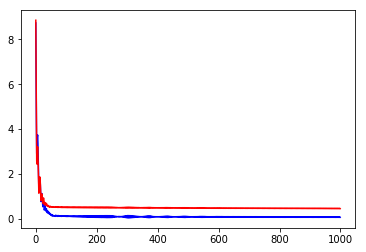

In [37]:
sess = tf.Session()
# variable 초기화
sess.run(tf.global_variables_initializer())    
# traing 시킬 데이터 수
num_examples = len(X_train)
print("Training ..")
print()

for i in range(EPOCHS):
    # train 데이터를 shuffling 후 사용 (여기서는 사용 안함)
    x_train_sh, y_train_sh = X_train, y_train

    # batch size 만큼씩 읽어서 training
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = x_train_sh[offset:end], y_train_sh[offset:end]

        # feed training data and run
        sess.run(training_op,feed_dict={x_placeholder:batch_x, y_placeholder:batch_y,prob:1.0})
    
    #검증용 test data accuracy 측정 (EPOCH 단위로)
    valid_loss = evaluate(X_test, y_test, sess)
    # train data accuracy 측정 (EPOCH 단위로)
    train_loss = evaluate(x_train_sh, y_train_sh,sess)
    
    # for graph
    list_train_loss.append(train_loss)
    list_valid_loss.append(valid_loss)

    print('\r',"EPOCH {} ...".format(i+1),
          "Validation Loss = {:.3f} ...".format(valid_loss),
          "Training Loss = {0:.3f} ...".format(train_loss),end='')
    if len(epochs) == 0:
        epochs.append(0)
    else:
        epochs.append(epochs[-1]+1)
    

#plotting Accuracy graph
plt.plot(epochs,list_train_loss,'b-',epochs,list_valid_loss,'r-')
plt.show()

## Predict

In [39]:
pred = hypothesis
# train 할 때와 마찬가지로 예측 할 feature 값들의 scale 을 조정
predicted_labels = sess.run(pred, feed_dict={x_placeholder: StandardScaler().fit_transform(X_submit),prob: 1.0})

# 예측은 log(x) 기준으로 학습한 결과값이기 때문에 원래 값으로 원복해야 함
predicted_labels = np.exp(predicted_labels)
predicted_labels

array([ 195462.265625 ,   79285.5625   ,  210668.15625  , ...,
        224072.953125 ,  107883.1796875,  239344.734375 ], dtype=float32)

## For Kaggle

In [40]:
# 제출용 데이터 생성
submission = pd.read_csv("data/sample_submission.csv", index_col="Id")
submission["SalePrice"] = predicted_labels
print(submission.shape)
submission.head()

(1459, 1)


,SalePrice
Id,
1461,195462.265625
1462,79285.562500
1463,210668.156250
1464,203447.187500
1465,253265.593750


In [41]:
# 저장할 파일을 구분하기 위해 파일명에 timestamp 정보 추가 하기 위한 작업 
from datetime import datetime

current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d_%H-%M-%S")

description = "house-tensorflow-basic"

filename = "{date}_{desc}.csv".format(date=current_date, desc=description)
filepath = "data/{filename}".format(filename=filename)

submission.to_csv(filepath, index=True)